- Use fixed threshold after whitening for detecting spikes

In [1]:
%reload_ext autoreload
%autoreload 2

from online_sorter_qtui import spike_data
from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns

import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

from scipy import signal 

from sklearn import *

from palettable.colorbrewer.qualitative import Dark2_4 as p4color

from utils import *

from time import sleep


C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# load data
def loadPackets(filename):

    data_list = []
    segment_count = 0
    with open(filename,'rb') as f:
        while True:
            try:
                data_list.append(pickle.load(f))
                segment_count +=1
            except EOFError:
                break

        print(f'Reached end. Total segment: {segment_count}')
    return data_list

data_list = loadPackets('data/data_packets_M2_D23_3.pkl')
data_list = [d for d in data_list if d]

Reached end. Total segment: 126868


In [4]:
Fs = 30000
spikes_data = [d['spike'] for d in data_list if 'spike' in d.keys()]
df_spikes = makeSpikeDataframe(spikes_data)
df_spikes.sort_values('timestamps',inplace=True)
print(len(df_spikes))
df_spikes.head()


111089


spike_waveform  \
0  [-5.7485013, -5.5810714, -11.215428, -16.83687...   
1  [-27.44911, -39.954662, -38.020676, -28.24411,...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                time  electrode_ids  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              2   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              0   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   

                                         channel_ids  spike_id  timestamps  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0       10081  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1       10197  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         2       10365  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         3       10409  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         4       10439

(27, 9413760)
8960


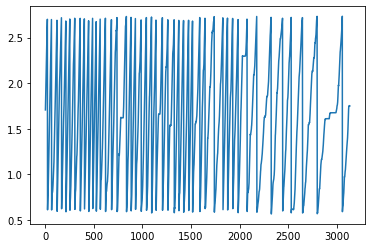

In [5]:
# collect the animal position
time_bin = 0.1
adc_data = [d['data'] for d in data_list if 'data' in d]
data_ts = [d['data_timestamp'] for d in data_list if 'data_timestamp' in d ]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_ts[0]
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
plt.plot(position)

neuroData = adc_data[:16,:]


In [ ]:
# ToDO: need to perform whitening
W = compute_whitenMatrix(neuroData[:,:10*30000])
neuroData_w = applyWhitening(neuroData,W)
# plt.figure(figsize=(18,15))
# plot_multichannel(neuroData[:,:30000],scale=20)

In [64]:
preSample = postSample = 20

spikes_list = detectSpike(neuroData_w,5, useAbsoluteThres=True)
print(len(spikes_list))
print(spikes_list[0])

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Spike threshold: [0.50882774 0.5417688  0.62815148 0.64432994 0.59156735 0.61733871
 0.52005197 0.5633803  0.64337209 0.65181786 0.63121898 0.63168838
 0.53937866 0.53803236 0.61121872 0.59668923]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.23s/it]

38794
electrode_id: 0, timestamp: 386, spikedata: (4, 40)


In [65]:
Fs = 30000
df_spikes = makeSpikeDataframe(spikes_list)
df_spikes = df_spikes.sort_values('timestamps').reset_index()
print(len(df_spikes))
df_spikes.head()

38794


index                                     spike_waveform  \
0   7686  [0.6130308380020142, 1.065905196503917, 1.1650...   
1   7687  [-0.12072056880744907, 0.0067435131865074, 0.9...   
2  25069  [0.6727705973958522, 0.5896043672506013, -0.29...   
3      0  [-0.024594072930735247, 0.04438319119984601, -...   
4      1  [-0.15050822048794044, -0.28114617713107326, 0...   

                                                time  electrode_ids  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              1   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              1   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              0   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              0   

                                         channel_ids  spike_id  timestamps  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      7686         215  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      7687         364  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     25069         369  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0         386  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1         738

In [66]:
# sorting
spikes2sort=2000
df_ref, df_online,template_cluster_id = sort_spikes_online(df_spikes.loc[:15000], df_spikes,pca_component=3)

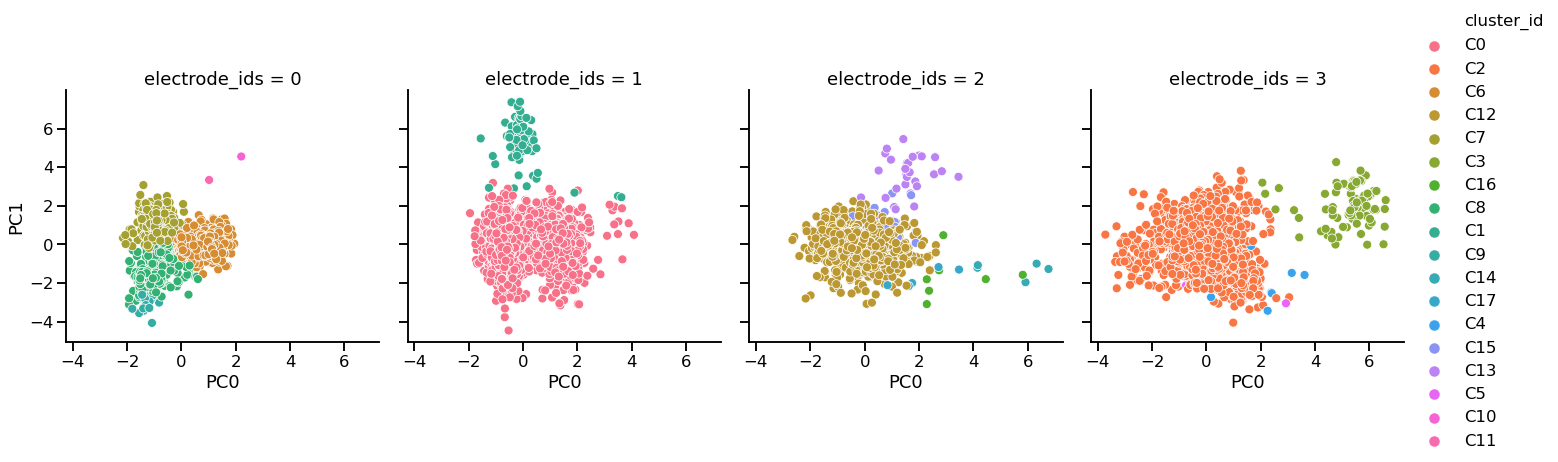

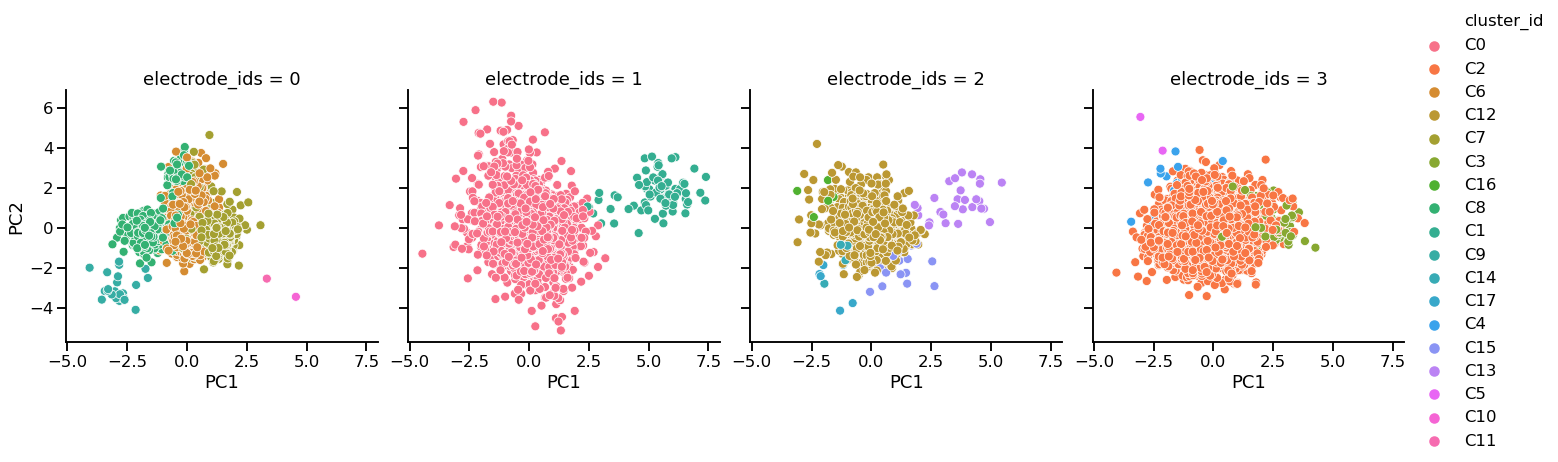

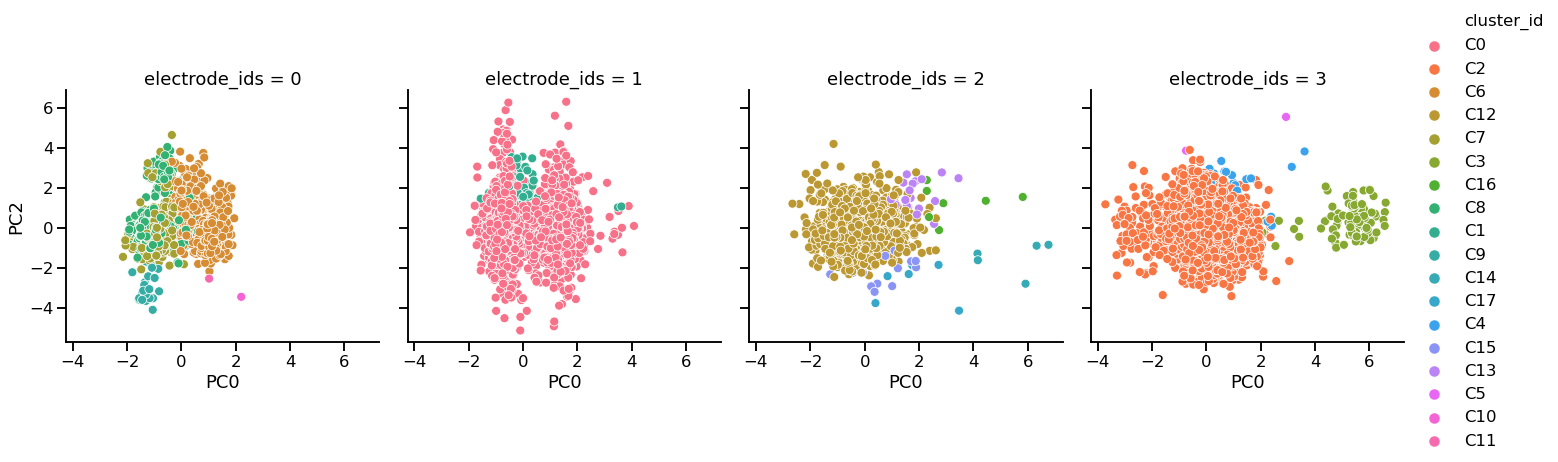

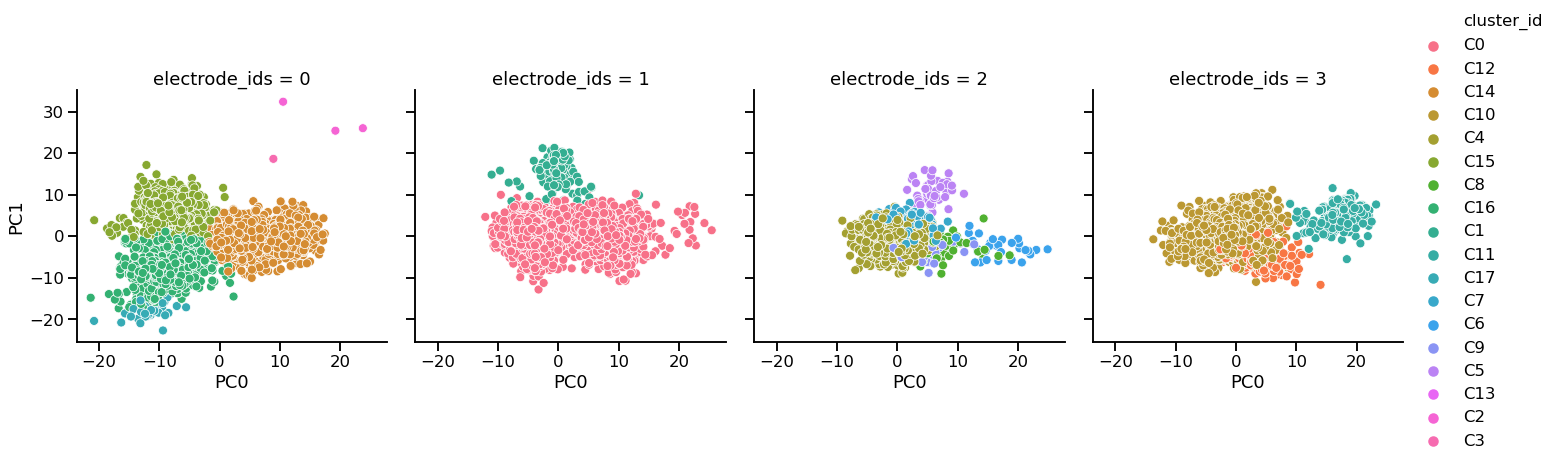

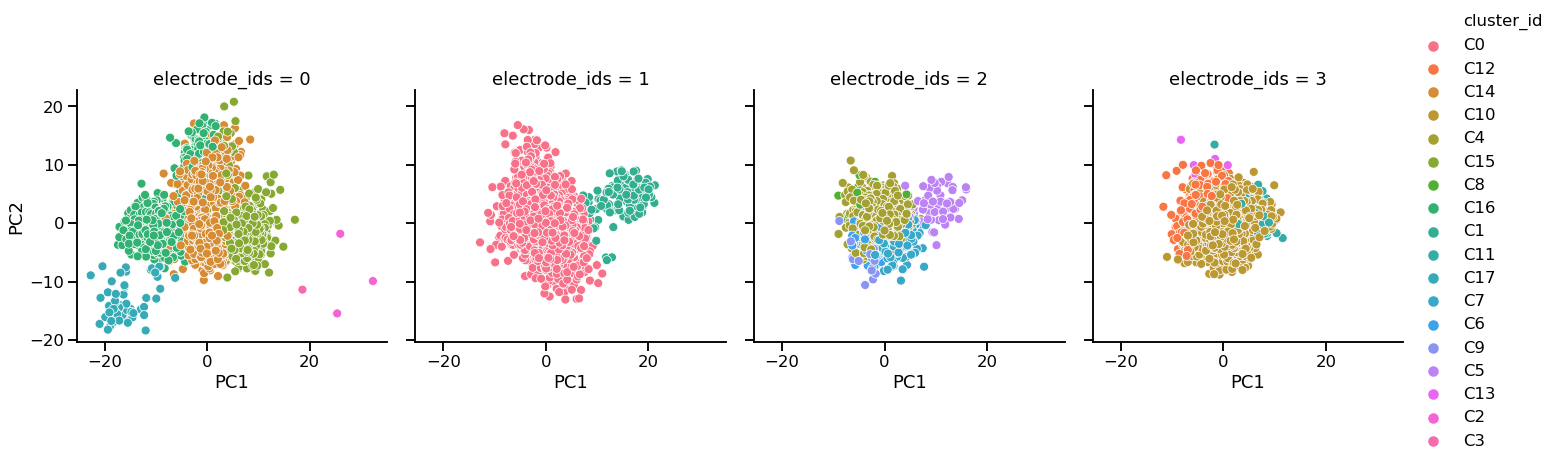

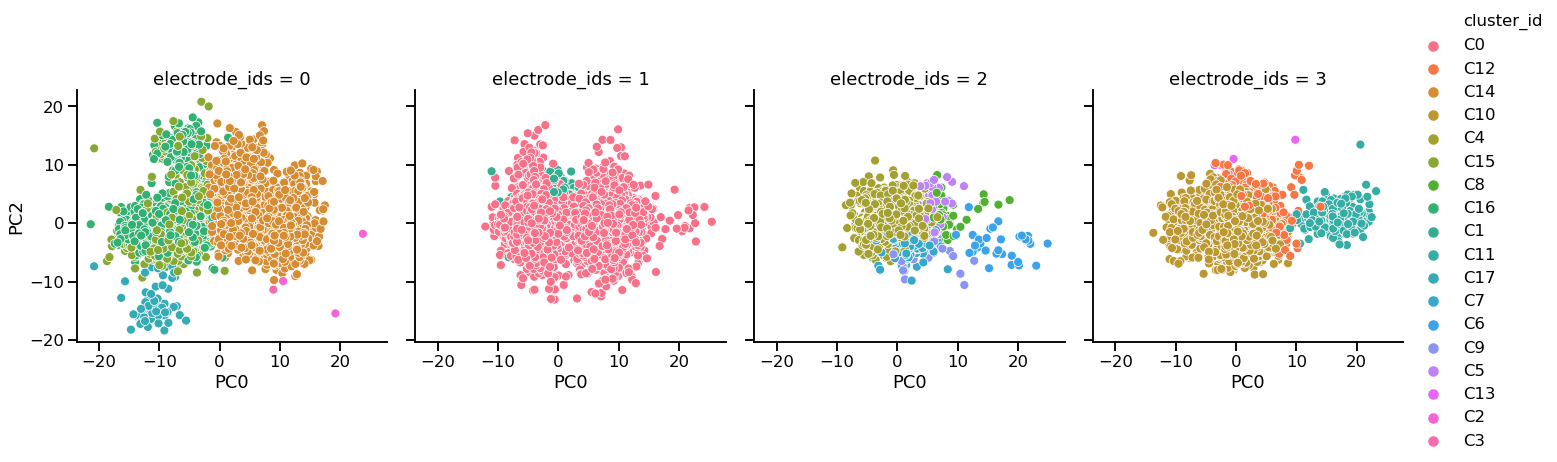

In [67]:
sns.set_context('talk',font_scale=1)

# training clustering
sns.relplot(x='PC0',y='PC1',hue='cluster_id', col='electrode_ids', col_wrap=4, data=df_ref)
sns.relplot(x='PC1',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4, data=df_ref)
sns.relplot(x='PC0',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4, data=df_ref)


# testing clusters
sns.relplot(x='PC0',y='PC1',hue='cluster_id', col='electrode_ids', col_wrap=4, data=df_online)
sns.relplot(x='PC1',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4, data=df_online)
sns.relplot(x='PC0',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4, data=df_online)


(18, 3137)
(3137, 7)


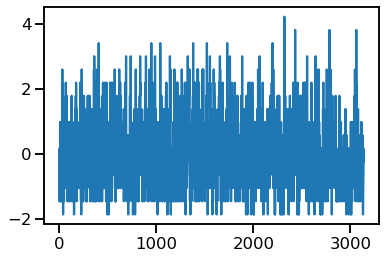

In [68]:
# make firing rate array
Fs = 30000
time_bin = 0.1
time_bin_start=0

df2decode = df_online

spike_time = (df2decode.timestamps.values)/Fs #shift timestamp
bins = np.arange(time_bin_start, spike_time.max(), time_bin )
spk_train, skp_time_event=sort2spiketrain(template_cluster_id, df2decode.cluster_id, spike_time, bins)
print(spk_train.shape)

# spk_train = spiketrain_ms4

#normalize the firing rate
scaler =preprocessing.StandardScaler()
meanFr = spk_train.mean(axis=1)
norm_spiketrain = scaler.fit_transform(spk_train[meanFr>0.1,:].T)
print(norm_spiketrain.shape)
# norm_spiketrain=spk_train.T
plt.plot(norm_spiketrain[:,0])

### Train decoder

In [69]:
norm_pos_online = position 

data_length = min(norm_spiketrain.shape[0], norm_pos_online.shape[0])
norm_spiketrain = norm_spiketrain[:data_length,:]
norm_pos_online = norm_pos_online[:data_length]

norm_pos_online = np.round((norm_pos_online-norm_pos_online.min())/(norm_pos_online.max()-norm_pos_online.min())*200)


(0.0, 1000.0)

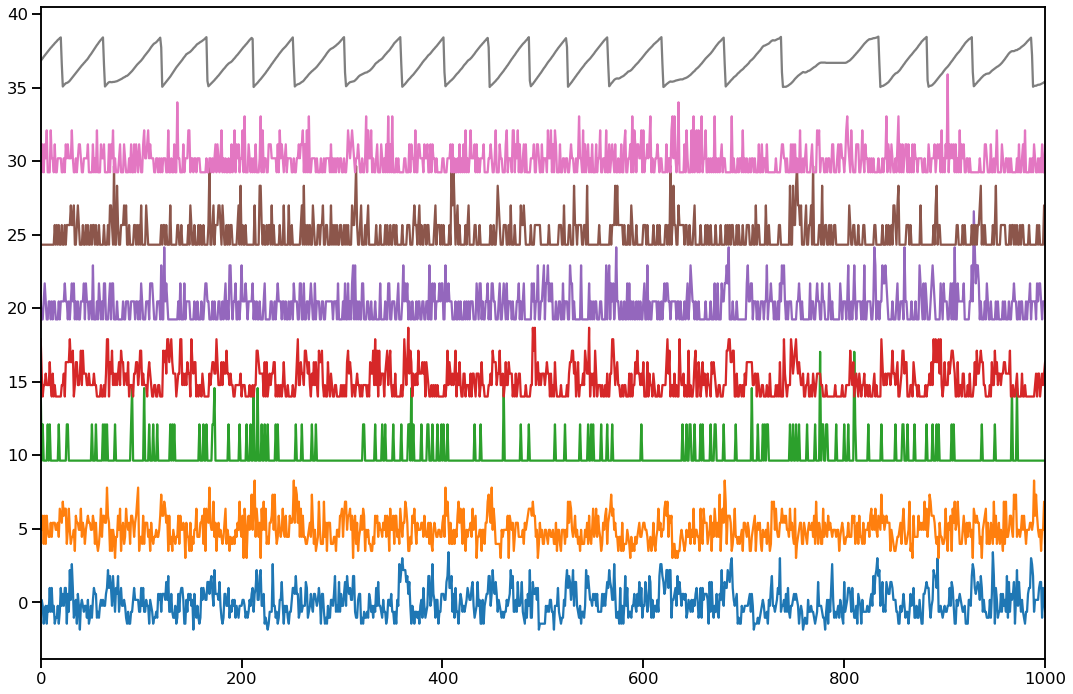

In [70]:
plt.figure(figsize=(18,12))
signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
plot_multichannel(signal2plot.T,scale=5)
plt.xlim([0,1000])
# plt.savefig('figures/aligned_fr.png')

R2 = 0.30 Variance-explained = 0.30


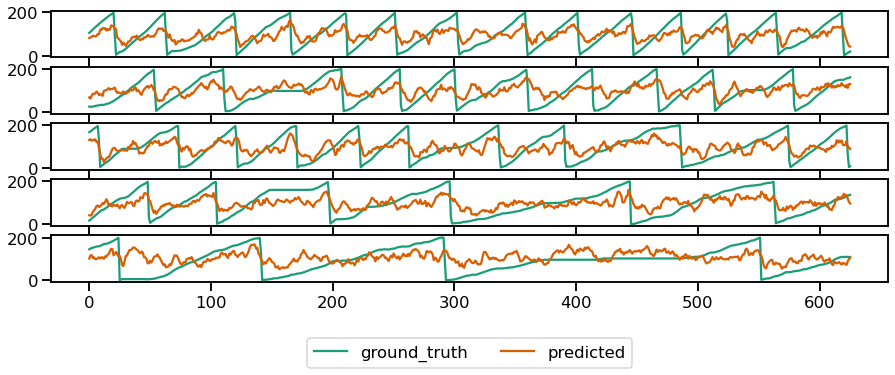

In [73]:
polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spiketrain)
poly_spiketrain = polyFeatures.transform(norm_spiketrain)

# regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,norm_pos_online)
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')

# featureName = np.array(polyFeatures.get_feature_names())
# idx = np.argsort(-regressor.coef_**2) #sorted feature index, descending
# sortedFeatureName = featureName[idx]
# print(sortedFeatureName)

predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,norm_pos_online.ravel(),cv=4)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(norm_pos_online.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(norm_pos_online.squeeze(),predicted_smooth.ravel())
print(f'R2 = {r2:.2f} Variance-explained = {varExplain:.2f}')
stripplot(norm_pos_online,predicted_smooth);


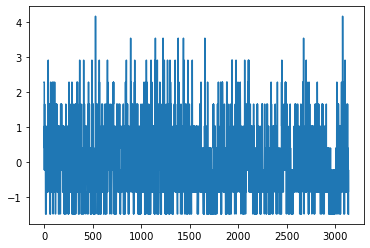

In [118]:
plt.plot(poly_spiketrain[:,featureName=='x1'])

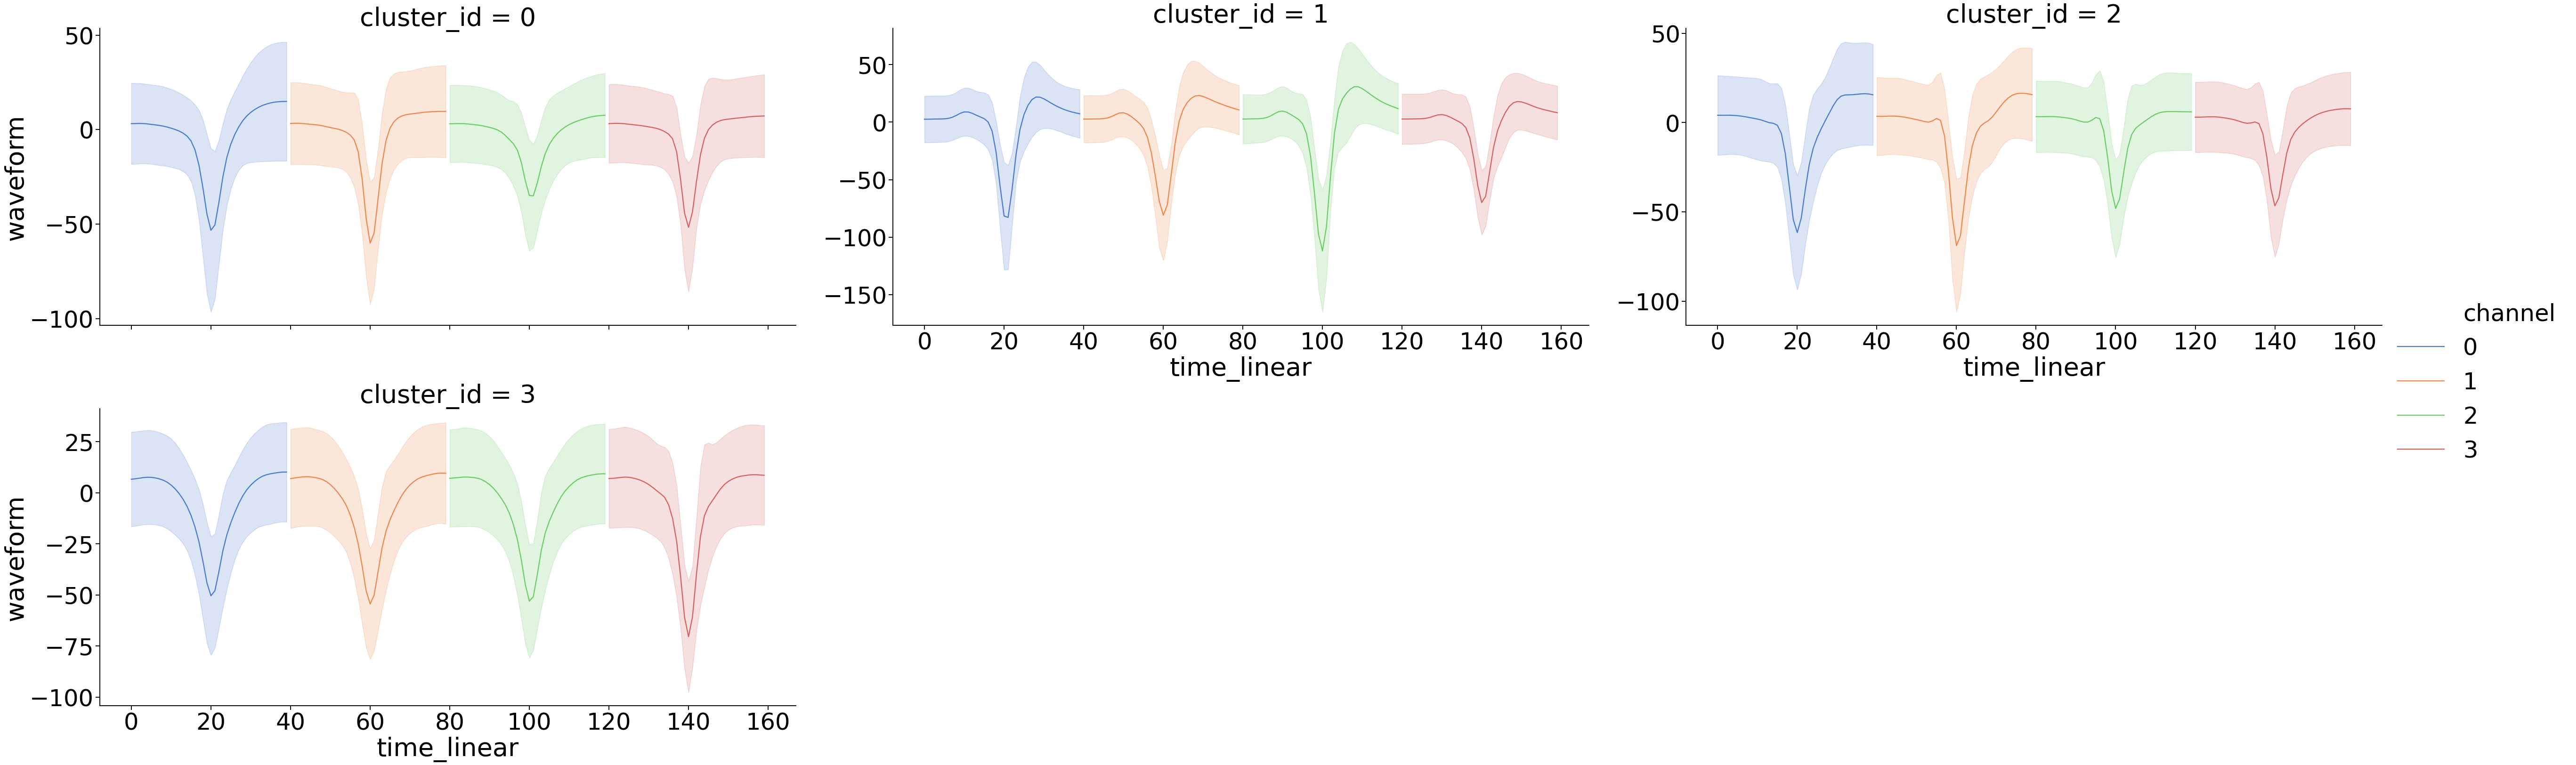

In [118]:
# offline spike detection
clusters = df_online.label_tm.unique()

waveforms = []

for c in clusters:
    spiketime = df_online[df_online.label_tm==c].timestamps
    electrode = df_online[df_online.label_tm==c].electrode_ids.values
    waveform = getSpikeWaveform(spiketime,electrode[0],neuroData)
    waveforms.append(waveform)
    
df_waveforms_median = spikeWaveform2DF(waveforms)

sns.set_context('talk',font_scale=3)
sns.relplot(y='waveform',x ='time_linear', hue='channel', col='cluster_id',
            col_wrap=3, height=12, aspect=2,
            kind='line',ci='sd',facet_kws={'sharey':False},palette='muted',data=df_waveforms_median)

plt.savefig('figures/median_spikedetect_waveform.png')

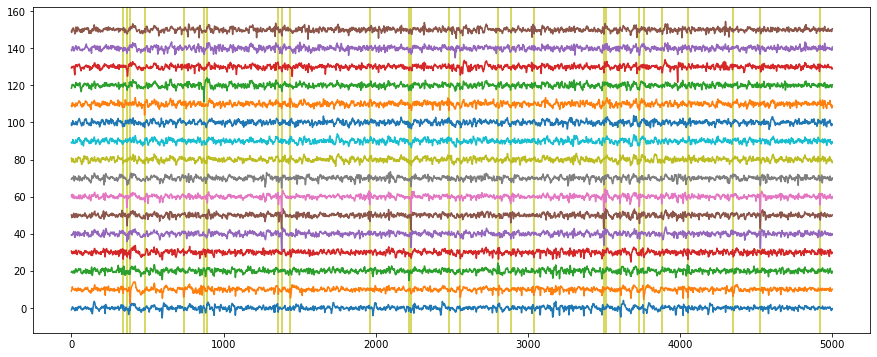

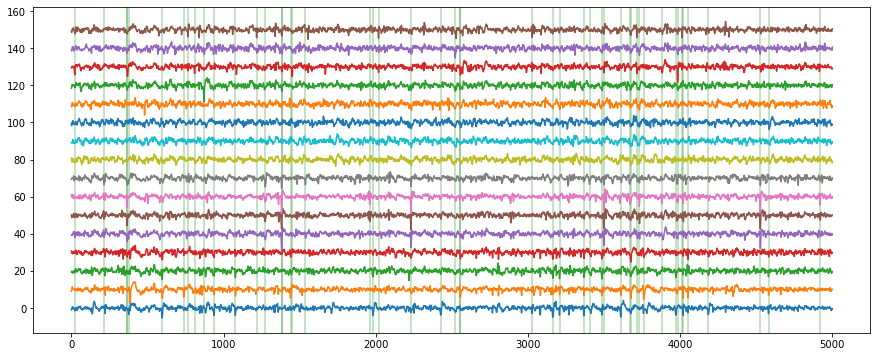

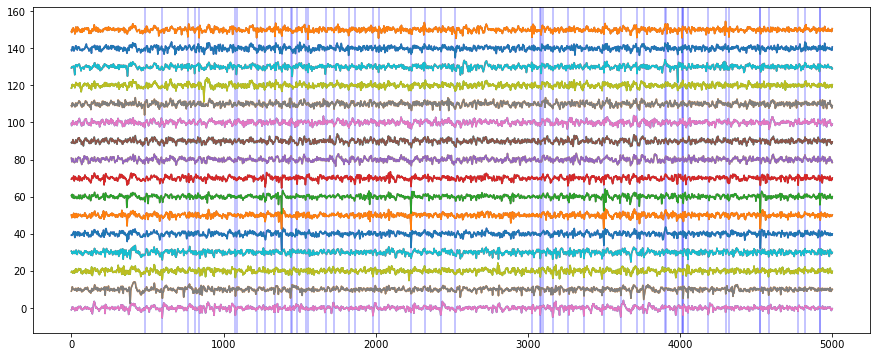

In [39]:
plot_range = 5000

plot_spikeEvent(neuroData,spiketime_ms4,plot_range,color='y',alpha=0.8)
plot_spikeEvent(neuroData,spiketime_median,plot_range,color='g',alpha=0.3)
plot_spikeEvent(neuroData,spiketime_online,plot_range,color='b',alpha=0.3)


plot_multichannel(neuroData[:,:plot_range],10)

In [114]:
data_list2 = loadPackets('data/data_packets_M2_D23_3.pkl')
adc_data2 = [d['data'] for d in data_list2 if 'data' in d]
spikes2 = [d['spike'] for d in data_list2 if 'spike' in d]
spiketimes2 = np.array([s.timestamp for s in spikes2])
adc_data2 = np.concatenate(adc_data2,1)
neurodata2 = adc_data2[:16,:]
plt.figure(figsize=(18,12))
# plot_multichannel(adc_data2[:16,:plot_range],10)

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import widgets

@interact(x=widgets.IntSlider(min=-3000, max=3000, step=1, value=0))
def shift_plot(x):
    plot_spikeEvent(adc_data2[:16,:],spiketimes2-x,1000,color='y')


Reached end. Total segment: 126868


<Figure size 1296x864 with 0 Axes>

interactive(children=(IntSlider(value=0, description='x', max=3000, min=-3000), Output()), _dom_classes=('widg…

462


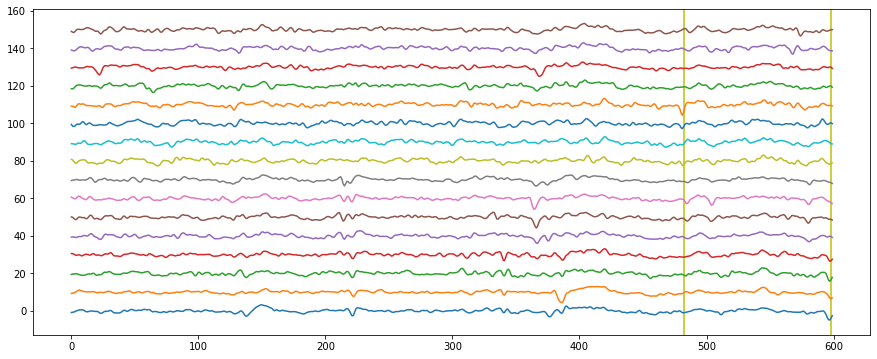

In [132]:
# match the timestamp of the data and spike
          
first_spike_data = spikes2[0].data
match_idx,electrode = findMatch(neurodata2[:,:10000],first_spike_data)
first_spike_time = spikes2[0].timestamp

spike_time_sync = spiketimes2-first_spike_time+match_idx+first_spike_data.shape[1]/2

print(match_idx)

plot_spikeEvent(adc_data2[:16,:],spike_time_sync,600,color='y')

{'n_channels': 4, 'n_samples': 40, 'electrode_id': 2, 'sorted_id': 0, 'timestamp': 10081, 'channel': 0, 'threshold': 4, 'source': 106}


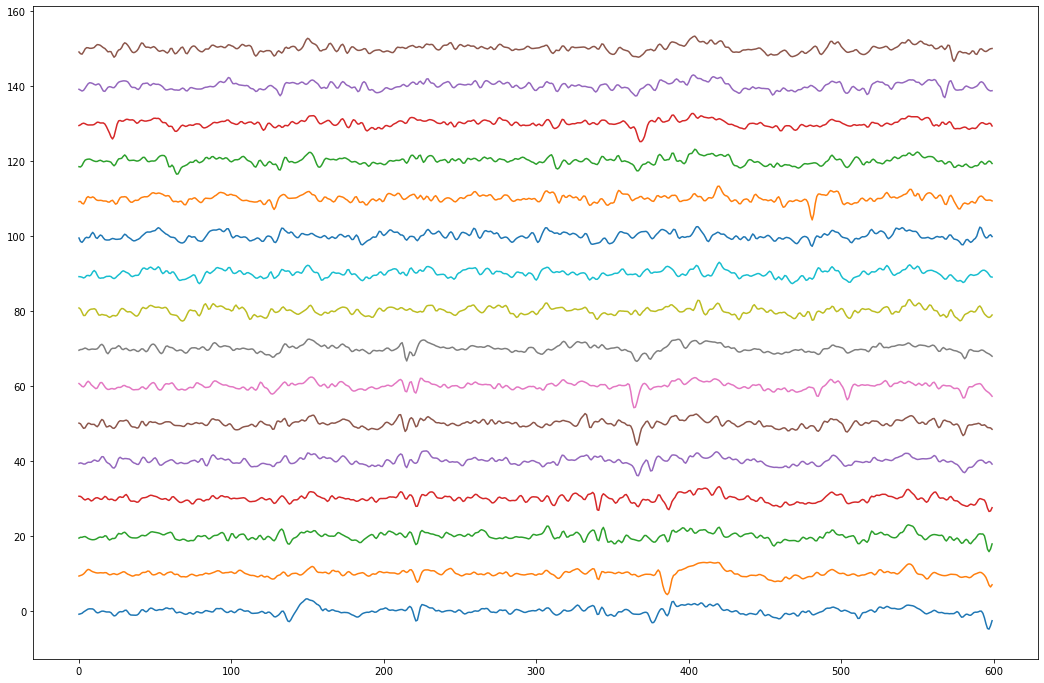

In [141]:
print(spikes2[0])
plt.figure(figsize=(18,12))
plot_multichannel(adc_data2[:16,:600],scale=10);
plt.savefig('figures/sample_timeseries.pdf')


In [256]:
# try to search for the matching spikes
x = spikes2[0].data
y=neurodata2[:,:5000]

def findMatch(y,x):
    #match position of x in y
    for j in range(4):
        for i in range(y.shape[1]-x.shape[1]):
            if np.allclose(y[j:j+4,i:i+x.shape[1]],x):
                return i


# np.correlate(y,x)
# plt.plot(np.correlate(y,x))
# plt.xlim([0,5000])

In [258]:
%timeit findMatch(y,x)

4.47 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [169]:
spikes2[:5]

[{'n_channels': 4, 'n_samples': 40, 'electrode_id': 1, 'sorted_id': 0, 'timestamp': 2, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 0, 'sorted_id': 0, 'timestamp': 4, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 1, 'sorted_id': 0, 'timestamp': 116, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 3, 'sorted_id': 0, 'timestamp': 694, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 3, 'sorted_id': 0, 'timestamp': 800, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40)]

### Decoding

In [36]:
time_bin_start = 0
start_timestamp = 0

bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain_ms4=np.stack(spiketrain)   

[[1.         0.23287466]
 [0.23287466 1.        ]]


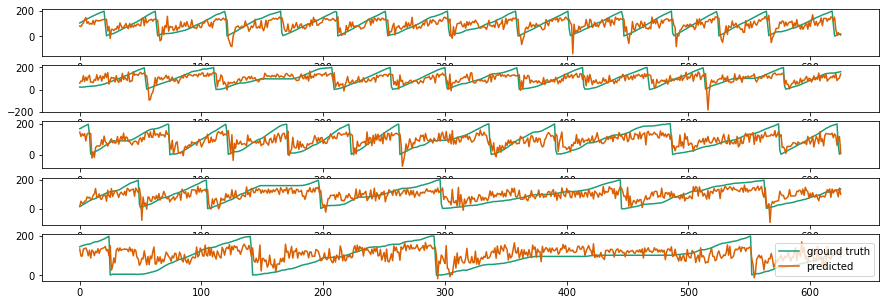

In [37]:
scaler =preprocessing.StandardScaler()
norm_spiketrain_ms4 = scaler.fit_transform(spiketrain_ms4.T)

norm_pos = np.round((position-position.min())/(position.max()-position.min())*200)

datalength = min(norm_spiketrain_ms4.shape[0], norm_pos.shape[0])
norm_spiketrain_ms4 = norm_spiketrain_ms4[:datalength,:]
norm_pos = norm_pos[:datalength]

poly_spiketrain_ms4 = preprocessing.PolynomialFeatures(2).fit_transform(norm_spiketrain_ms4)
# poly_spiketrain_ms4 = polyFeatures_ms4.transform(norm_spiketrain_ms4)
lasso_ms4 = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain_ms4,norm_pos)

predicted_ms4 = model_selection.cross_val_predict(lasso_ms4,poly_spiketrain_ms4,norm_pos,cv=4)
bestCoeff_ms4 = np.corrcoef(norm_pos.squeeze(),predicted_ms4)
print(bestCoeff)

stripplot(norm_pos,predicted_ms4);

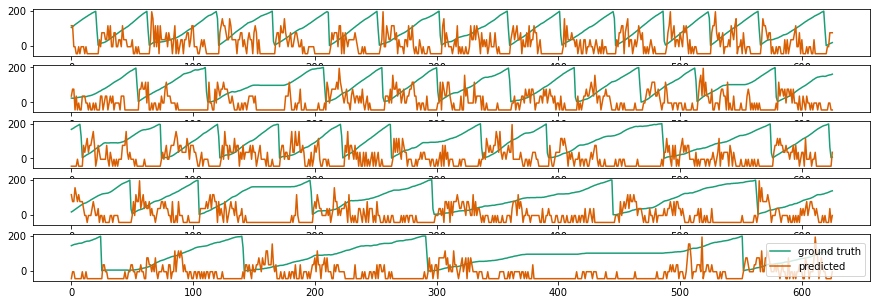

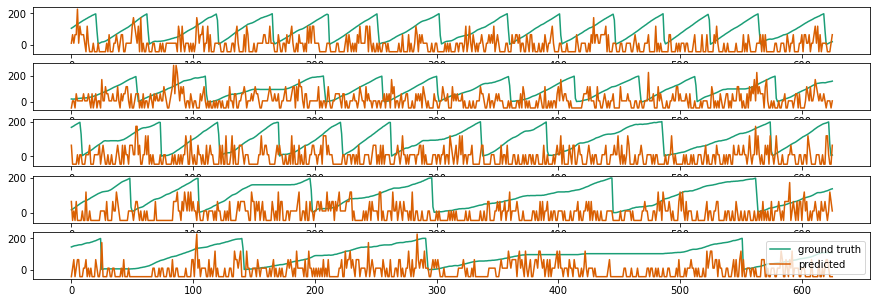

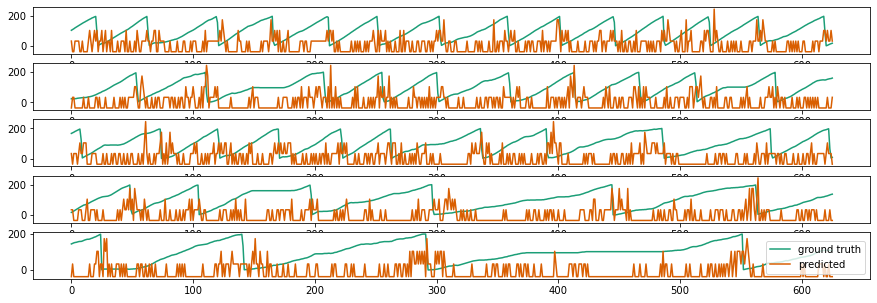

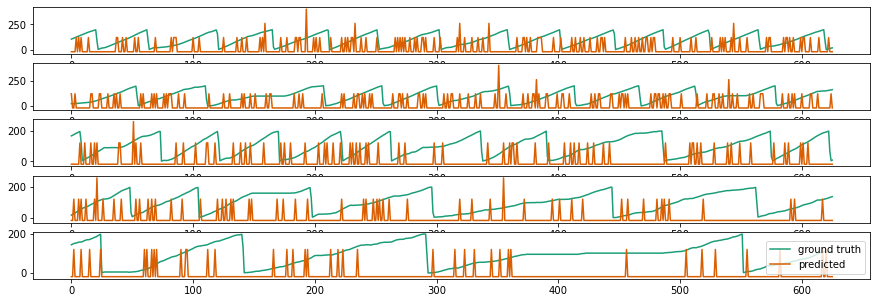

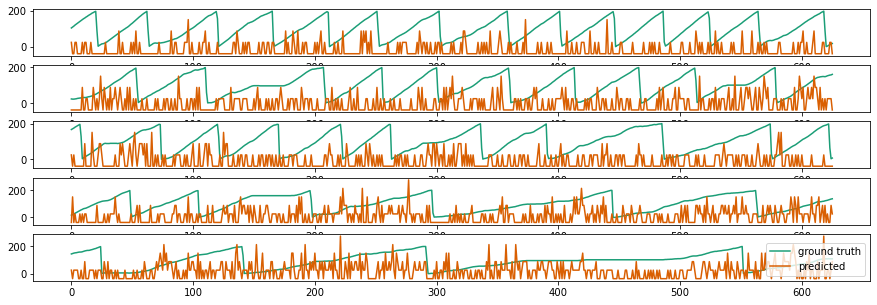

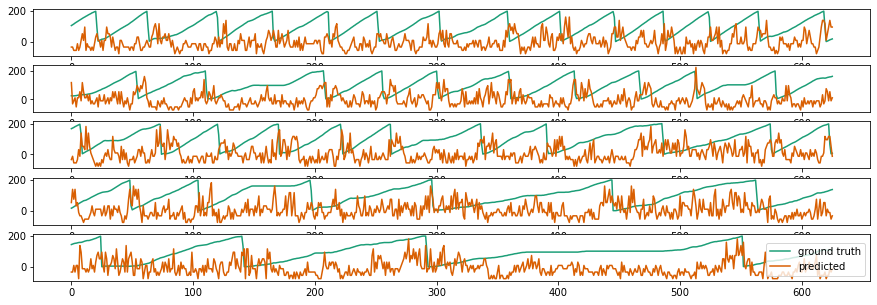

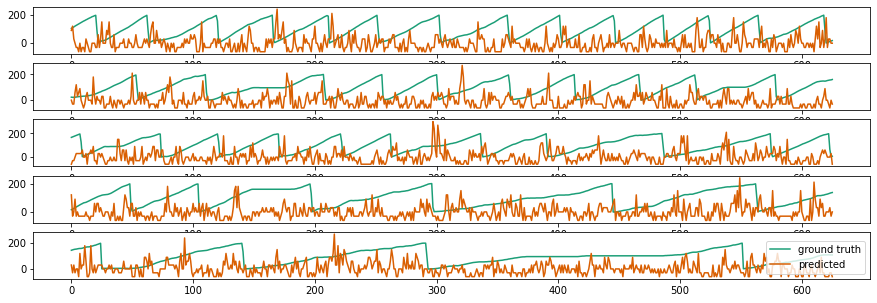

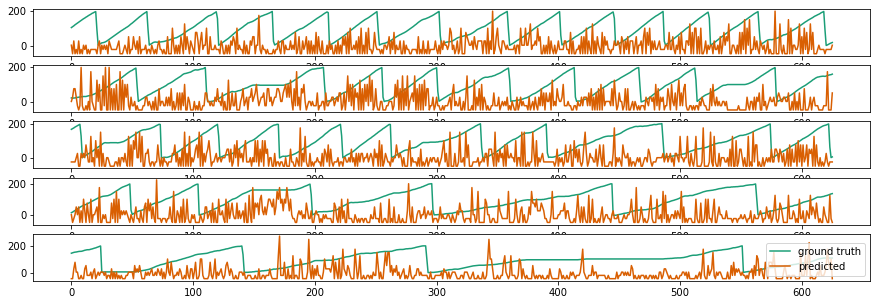

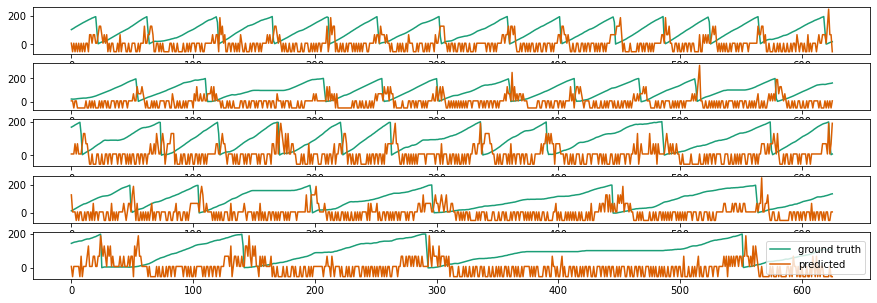

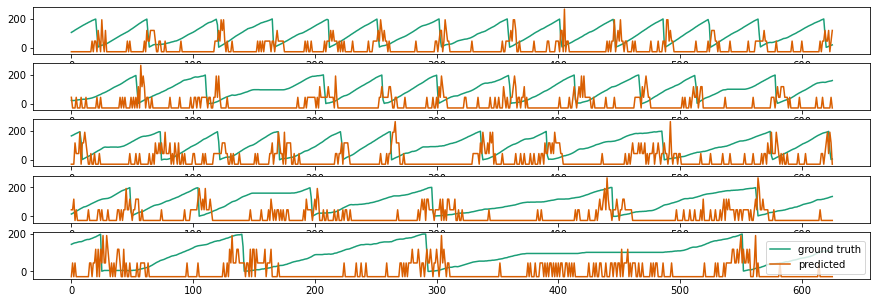

In [38]:
for i in range(norm_spiketrain_ms4.shape[1]):
    stripplot(norm_pos,norm_spiketrain_ms4[:,i]*50);

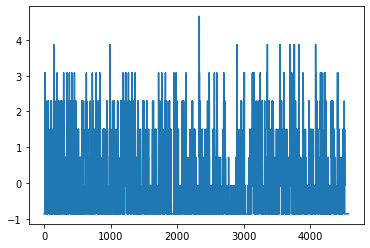

In [43]:
plt.plot(norm_spiketrain_ms4[:,2])

In [44]:
df_decoded = pd.read_pickle('data/decoded_data.pkl')

In [47]:
df_decoded.sort_values('meanScore',ascending=False)

model                                  sortedFeatureName  \
112  Lasso(alpha=0.1)  [x2, x0, x3, x10, x12, x2^2, x9, x13, x15, x2 ...   
120  Lasso(alpha=0.1)  [x2, x14, x9, x8, x2^2, x2 x14, x3, x14^2, x9 ...   
97   Lasso(alpha=0.1)  [x3, x15, x16, x3^2, x3 x16, x14, x17, x19, x2...   
121  Lasso(alpha=0.1)  [x15, x16, x5 x15, x10, x1, x10 x14, x13 x15, ...   
105  Lasso(alpha=0.1)  [x8, x3, x0, x4, x0 x5, x5 x8, x8^2, x3 x8, x2...   
..                ...                                                ...   
0    Lasso(alpha=0.1)                                      [x0, x0^2, 1]   
94   Lasso(alpha=0.1)  [x5, x2, x6, x4, x1, x5 x8, x5^2, x8, x6 x8, x...   
31   Lasso(alpha=0.1)  [x4, x2, x3, x1, x5, x5^2, x1 x3, x2^2, x3 x5,...   
84   Lasso(alpha=0.1)  [x12, x7, x13, x8, x10, x7 x12, x5, x6, x11, x...   
48   Lasso(alpha=0.1)  [x11, x10, x9, x2, x1, x5, x0, x2 x9, x3, x4, ...   

       meanScore                                             scores  \
112     0.390540  [0.20939310126147365, 0.26086171584513046, 0.2...   
120     0.370806  [0.18506497320448698, 0.18449288057857466, 0.2...   
97      0.334787  [0.24008593355009583, 0.25857119736991124, 0.2...   
121     0.331282  [0.11670965287913677, 0.1333439467175645, 0.16...   
105     0.293779  [0.1996118438120077, 0.1989804616260172, 0.250...   
..           ...                                                ...   
0    -283.903591         [-241.30446237785492, -283.90359116203456]   
94   -453.546058  [-214.41636449955573, -453.5460576483923, -470...   
31   -493.398021  [-261.2327942672108, -493.398021304907, -772.6...   
84  -2940.240539  [-2447.0034090795916, -2456.564698315384, -226...   
48  -5618.663693  [-5825.793639835601, -5109.367871926325, -5618...   

     bestNumfeature                                session  
112              66    cohort_4:M2_D23_2019-04-03_13-34-00  
120             101    cohort_4:M2_D25_2019-04-05_12-44-59  
97               85    cohort_4:M2_D24_2019-04-04_13-22-05  
121              98    cohort_4:M2_D27_2019-04-09_13-04-27  
105              28    cohort_4:M2_D16_2019-03-25_13-22-42  
..              ...                                    ...  
0                 1  cohort_2:1124_D10_2018-10-29_11-12-49  
94                1    cohort_3:M1_D21_2018-10-16_11-54-11  
31                1    cohort_2:245_D3_2018-10-20_10-56-04  
84                3    cohort_3:M1_D25_2018-10-19_13-01-11  
48                2     cohort_3:M1_D7_2018-09-14_13-13-03  

[152 rows x 6 columns]

In [54]:
df_decoded[df_decoded.session.str.match('.*M1_D4.*')]

model                                  sortedFeatureName  \
92  Lasso(alpha=0.1)  [x2, x1, x1 x2, x3, x1 x3, x2^2, x3^2, x0 x2, ...   

    meanScore                                             scores  \
92   0.021963  [0.01994906820348765, 0.02211494862908987, 0.0...   

    bestNumfeature                             session  
92               2  cohort_3:M1_D4_2018-09-09_12-09-53

## tuning curves

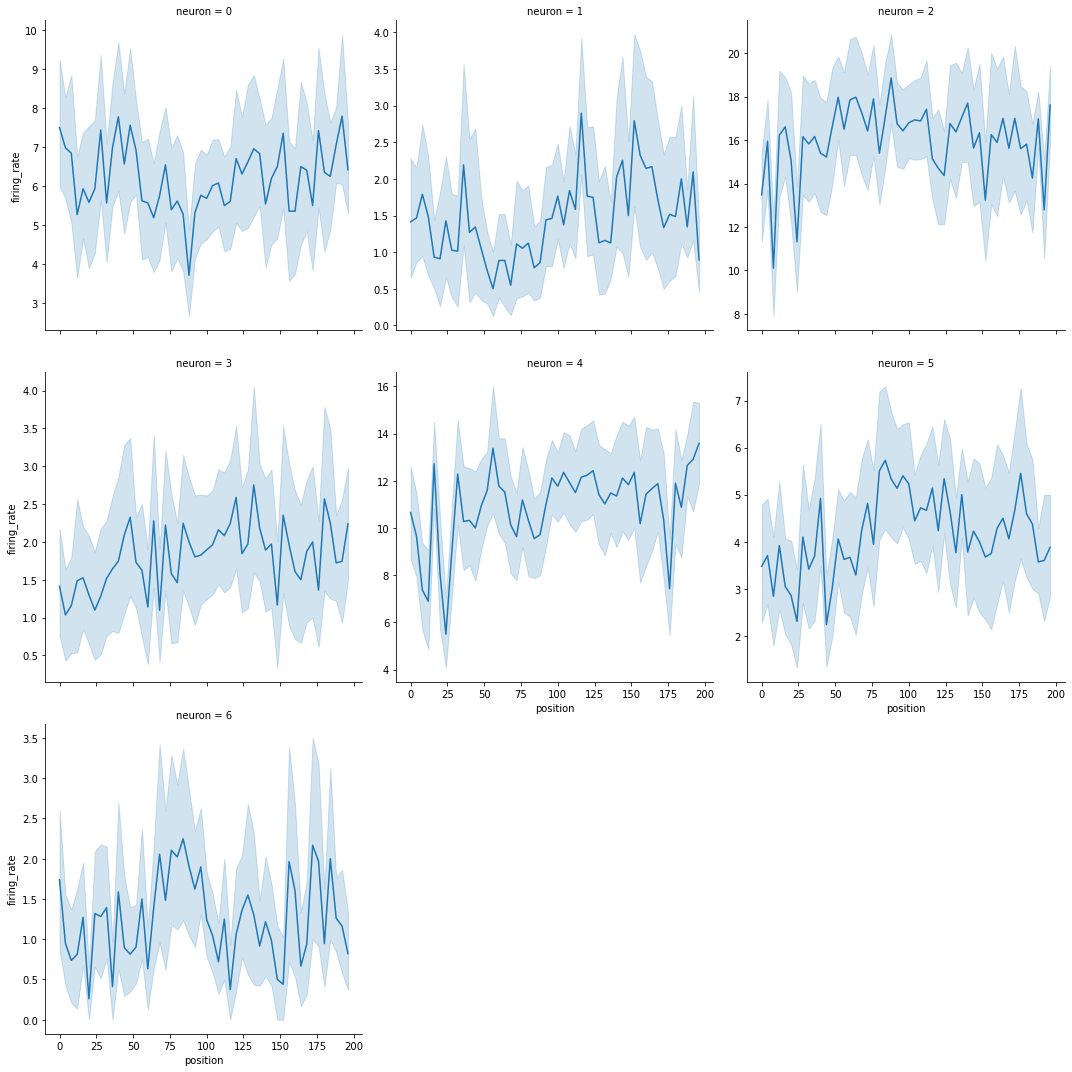

In [140]:
# calculate tuning curve

df_online_tc = makeTuningDataframe(position,spk_train.T,time_bin)

sns.relplot(x='position',y='firing_rate',col='neuron',col_wrap=3, kind="line",
    facet_kws = {'sharey':False},data=df_online_tc)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



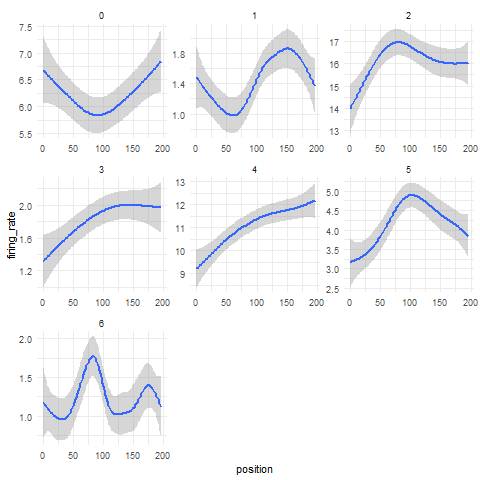

In [141]:
%%R -i df_online_tc
ggplot(df_online_tc) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
# ggsave('online_tuningcurve.pdf')

## Offline sorting using spike interface

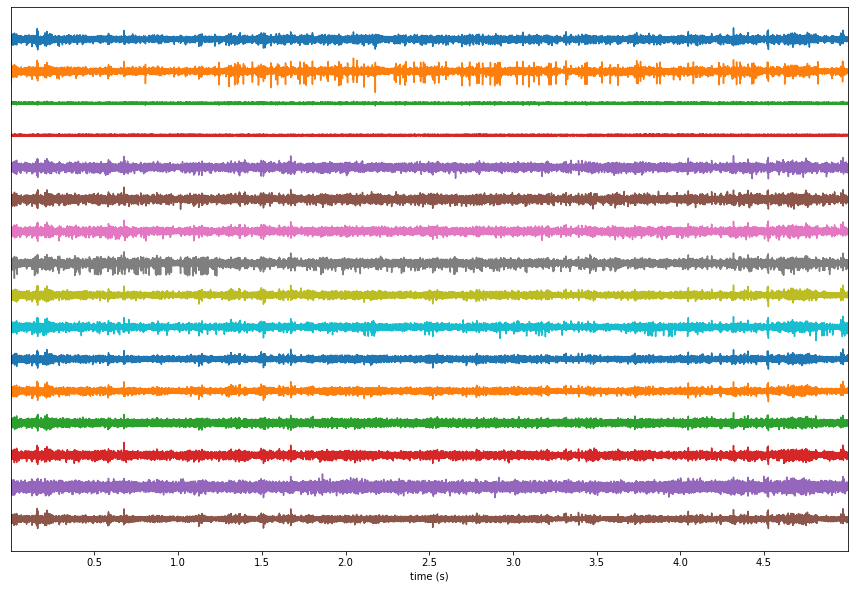

In [142]:
neuroData = adc_data[:16,:]
recording = se.NumpyRecordingExtractor(timeseries=neuroData,sampling_frequency=Fs)
recording.load_probe_file('tetrode_16.prb')
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax);

In [143]:
 #required for mountasort to store intermediate data
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True)

env: TEMPDIR=C:\tmp
WARNING! No channel location given. Add dummy location.
Using 2 workers.
Using tmpdir: C:\tmp\tmp6fpmdcde
Num. workers = 2
Preparing C:\tmp\tmp6fpmdcde/timeseries.hdf5...
'end_frame' set to 13849600
Preparing neighborhood sorters (M=16, N=13849600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmp6fpmdcde
mountainsort4 run time 145.57s


In [144]:
# curation
sorting_ms4_curated = st.curation.threshold_snrs(sorting=sorting_MS4_2, recording = recording,
  threshold = 4, threshold_sign='less',
    max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rates(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less', duration_in_frames=recording.get_num_frames())
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, 
    threshold = 0.9,duration_in_frames=recording.get_num_frames(), threshold_sign='greater' )
print(sorting_ms4_curated.get_unit_ids())


Impossible to delete temp file: C:\Users\teristam\AppData\Local\Temp\tmpbjb6p_g6 Error [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\teristam\\AppData\\Local\\Temp\\tmpbjb6p_g6\\waveforms_1.raw'
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]


In [145]:
time_bin_start = 0
bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain=np.stack(spiketrain)    

# make frame for plotting
df_ms4 = makeTuningDataframe(position, spiketrain.T,time_bin)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



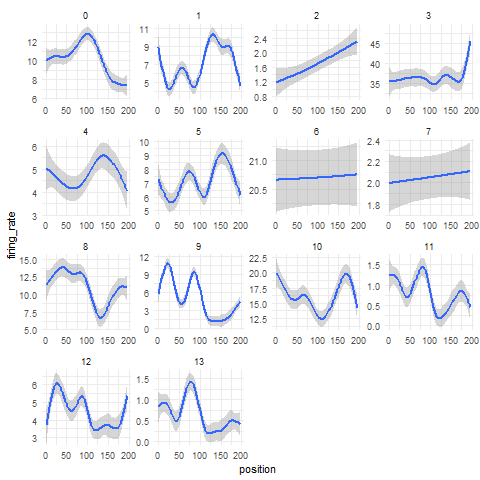

In [146]:
%%R -i df_ms4
options(repr.plot.width=12, repr.plot.height=8)

ggplot(df_ms4) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
    
# ggsave('ms4_tuningcurve.pdf')